In [34]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

---

In [35]:
def resize_image(im, max_size=768):
    if np.max(im.shape) > max_size:
        ratio = max_size / np.max(im.shape)
        print(f"Resize image to ({str(int(im.shape[1]*ratio))}, {str(int(im.shape[0]*ratio))}).")
        return cv2.resize(im, (0,0), fx=ratio, fy=ratio)
    return im

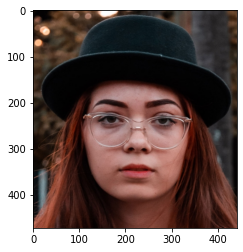

In [36]:
# Test images are obtained on https://www.pexels.com/
im = cv2.imread(r"C:\\Users\\jason\\face_recognition_tensorflow_lite\\test.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

---
# 0. Coordinate ordering

The coordinate in this demo has ordering `(x, y)`, which follows the format fo numpy array: `x` is the vertical axis and `y` the horizontal axis.

---
# 1. Face detection

Face deteciton using S3FD and FAN.

In [40]:
import importlib
from models.detector import face_detector
importlib.reload(face_detector)
from models.detector.s3fd import s3fd_detector
importlib.reload(s3fd_detector)

<module 'models.detector.s3fd.s3fd_detector' from 'C:\\Users\\jason\\face_toolbox_keras-master\\models\\detector\\s3fd\\s3fd_detector.py'>

In [41]:
fd = face_detector.FaceAlignmentDetector(
    lmd_weights_path="./models/detector/FAN/2DFAN-4_keras.h5"# 2DFAN-4_keras.h5, 2DFAN-1_keras.h5
)

1
2
3
loading S3FD model............
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, None, None, 6 1792        input_11[0][0]                   
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, None, None, 6 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_51 (MaxPooling2D) (None, None, None, 6 0           conv1_2[0][0]                    
________________________________________________________________________

## Detect faces

In [42]:
bboxes = fd.detect_face(im, with_landmarks=False)

4
5
6
first image shape: (472, 442, 3)
after image shape: (1, 472, 442, 3)
s3fd cost: 0.3418097496032715 

output length: 12
output type: <class 'list'>
output: [array([[[[ 1.1735008, -1.9751987],
         [ 1.474236 , -1.7915652],
         [ 1.3363049, -1.9316323],
         ...,
         [ 1.2560525, -2.0905836],
         [ 1.1958463, -2.1761918],
         [ 1.0240681, -2.163237 ]],

        [[ 1.1422733, -1.9708863],
         [ 1.4662648, -1.7090499],
         [ 1.4302869, -1.9327703],
         ...,
         [ 1.9613523, -1.2516953],
         [ 2.001361 , -1.1869767],
         [ 1.5327852, -1.5749243]],

        [[ 0.8094919, -2.4354997],
         [ 1.3019915, -2.2481713],
         [ 1.6695948, -2.400503 ],
         ...,
         [ 1.9834919, -1.3964561],
         [ 2.0044417, -1.2383647],
         [ 1.4271526, -1.6838121]],

        ...,

        [[ 1.4358021, -1.9205338],
         [ 2.0696926, -1.4075476],
         [ 2.2357922, -1.2279932],
         ...,
         [ 1.8300319, -1.67

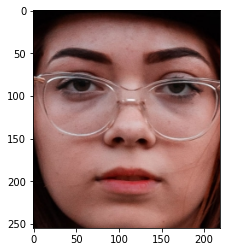

In [43]:
assert len(bboxes) > 0, "No face detected."

# Display detected face
x0, y0, x1, y1, score = bboxes[0] # show the first detected face
x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])

plt.imshow(im[x0:x1, y0:y1, :])

## Detect faces and landmarks

`FaceDetector` will instantiate `FANLandmarksDetector` when calling `detect_face(with_landmarks=True)` the first time.

In [ ]:
bboxes, landmarks = fd.detect_face(im, with_landmarks=True)

In [ ]:
print(landmarks)
print(bboxes)

In [ ]:
# Display landmarks
plt.figure(figsize=(15,8))
num_faces = len(bboxes)
for i in range(num_faces):
    try:
        plt.subplot(1, num_faces, i+1)
        plt.imshow(fd.draw_landmarks(im, landmarks[i], color=(0,255,0)))
    except:
        pass

---
# 2. Face parsing

Face parsing using BiSeNet.

In [ ]:
from models.parser import face_parser

In [ ]:
prs = face_parser.FaceParser()

## Parse without deteciton

In [ ]:
out = prs.parse_face(im)

In [ ]:
plt.imshow(out[0])

In [ ]:
# Show parsing result with annotations

from utils.visualize import show_parsing_with_annos
show_parsing_with_annos(out[0])

## Parse with detection

Parsing network has its best performance on single face (even better if aligned).

In [ ]:
im = cv2.imread("images/eric.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

In [ ]:
# Set detector into FaceParser
try:
    fd
except:
    from detector import face_detector
    fd = face_detector.FaceAlignmentDetector()
    
prs.set_detector(fd)
# prs.remove_detector()

In [ ]:
out = prs.parse_face(im, with_detection=True)

In [ ]:
#plt.figure(figsize=(15,8))
num_faces = len(out)
for i in range(num_faces):
    try:
        plt.subplot(1, num_faces, i+1)
        plt.imshow(out[i])
    except:
        pass

---
# 3. Detect irises

Iris detection using ELG (Eye region Landmarks based Gaze estimation).

In [ ]:
from models.detector.iris_detector import IrisDetector

## Detect iris, eyelibs and pulpils

In [ ]:
im = cv2.imread("images/5.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

In [ ]:
idet = IrisDetector()

In [ ]:
idet.set_detector(fd)

In [ ]:
eye_lms = idet.detect_iris(im)
left = eye_lms[0][0,...]
print(left)
print(len(left))

In [ ]:
# Display detection result
plt.figure(figsize=(15,10))
draw = idet.draw_pupil(im, eye_lms[0][0,...]) # draw left eye
draw = idet.draw_pupil(draw, eye_lms[0][1,...]) # draw right eye
bboxes = fd.detect_face(im, with_landmarks=False)
x0, y0, x1, y1, _ = bboxes[0].astype(np.int32)
plt.subplot(1,2,1)
plt.imshow(draw)
plt.subplot(1,2,2)
plt.imshow(draw[x0:x1, y0:y1])

---
# 4. Face verification

Face verification using facenet.

In [ ]:
from models.verifier.face_verifier import FaceVerifier

In [ ]:
im1 = cv2.imread(r"C:\\Users\\jason\\face_recognition_tensorflow_lite\\test.jpg")[..., ::-1]
im1 = resize_image(im1) # Resize image to prevent GPU OOM.
im2 = cv2.imread(r"C:\\Users\\jason\\face_recognition_tensorflow_lite\\test.jpg")[..., ::-1]
im2 = resize_image(im2) # Resize image to prevent GPU OOM.
im3 = cv2.imread(r"C:\\Users\\jason\\face_recognition_tensorflow_lite\\test.jpg")[..., ::-1]
im3 = resize_image(im3) # Resize image to prevent GPU OOM.

In [ ]:
fv = FaceVerifier(classes=512, extractor="insightface") # extractor="insightface"

In [ ]:
fv.set_detector(fd)

## Verify if two given faces are the same person

In [ ]:
# Face verification
result1, distance1= fv.verify(im1, im2, threshold=0.5, with_detection=True, with_alignment=False, return_distance=True)
result2, distance2 = fv.verify(im1, im3, threshold=0.5, with_detection=True, with_alignment=False, return_distance=True)

print(location1)
print(location2)


In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.title(f"Source face")
plt.imshow(im1)
plt.subplot(1,3,2)
plt.title(f"Same person: {str(result1)}\n Cosine distance: {str(round(distance1, 2))}")
plt.imshow(im2)
plt.subplot(1,3,3)
plt.title(f"Same person: {str(result2)}\n Cosine distance: {str(round(distance2, 2))}")
plt.imshow(im3)

---
# 5. Gender and Age Estimation

Gender/Age estimation using insightface mobilenet.

In [ ]:
from models.estimator.gender_age_estimator import GenderAgeEstimator

In [ ]:
im = cv2.imread("images/BO1.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

In [ ]:
gae = GenderAgeEstimator(model_type="insightface")

In [ ]:
gae.set_detector(fd)

In [ ]:
gender, age = gae.predict_gender_age(im, with_detection=True)

In [ ]:
print("Gender: female") if gender == 0 else print("Gender: male")
print(f"Age: {str(age)}")

## test

In [ ]:
fv.build_face_identity_database(r"C:\Users\jason\Facial-Recognition-FaceNet-master\database\id")